# Data Processing for Automatic Pancreas Tissue Segmentation

## Import python libraries

In [9]:
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.transform import resize

import matplotlib.pyplot as plt
import os
import glob
import random
from tqdm.auto import tqdm
from itertools import chain
import sys

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.imgaug import show_grid
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from utils import *

import pathlib

## Desired output tile size

In [2]:
# tile cut size (from 2048 we would get 4 tiles without overlap)
ORIG = 2023
CUT_WIDTH = 1024
IMG_CHANNELS = 3

# final size to resize tile to
TARGET_WIDTH = 512

# path of exported annotated tiles from QuPath
DATASET_DIR = "qupath_export"

## Preview one tile

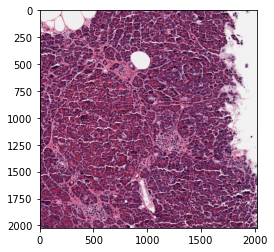

In [3]:
img = imread(os.path.join(DATASET_DIR, "GTEX-ZPCL-0726.svs_0\images\GTEX-ZPCL-0726.svs_(1.00,46539,30352,2023,2023).jpg"))
plt.imshow(img)

## Helper functions

In [4]:
def get_pixel_value_of_object(obj):
    d = {"Islets": 6,
         "Fat": 5,
         "Vessels": 4,
         "Ducts": 3,
         "tissue": 2,
         "Other": 1,
        }
    if obj in d:
        return d[obj]
    return 0

def merge_masks(mask_paths, height, width):
    mask = np.zeros((height, width, 1), dtype=np.bool)
    for mask_file in mask_paths:
        mask_ = imread(mask_file)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.maximum(mask, mask_)
    return mask

## Cut big tiles to a smaller ones

In [5]:
OUTPUT_FOLDER = f"data{TARGET_WIDTH}"
OUTPUT_IMAGES = OUTPUT_FOLDER + "/images"
OUTPUT_MASKS = OUTPUT_FOLDER + "/annotations"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_IMAGES, exist_ok=True)
os.makedirs(OUTPUT_MASKS, exist_ok=True)

# we'll get 4 tiles with a small overlap because source tile is not 2048
crops = [
    [0,CUT_WIDTH, 0,CUT_WIDTH],
    [0,CUT_WIDTH, ORIG-CUT_WIDTH, ORIG],
    [ORIG-CUT_WIDTH, ORIG, ORIG-CUT_WIDTH, ORIG],
    [ORIG-CUT_WIDTH, ORIG, 0,CUT_WIDTH]
]

## if using different crops, better to write it programmatically e.g:
# crops = [[i*496, j*496, (i*496)+496, (j*496)+496] for i in range(0,4) for j in range(0,4)]

print(crops)

[[0, 1024, 0, 1024], [0, 1024, 999, 2023], [999, 2023, 999, 2023], [999, 2023, 0, 1024]]


## Process tiles and save
1. Loads individual masks from files
2. Stack them by order of obj_name array (Islets last = highest priority)
3. Resize image (in this case from 1024 to 512 to train faster)

In [17]:
images_array = []
masks_array = []

obj_names = ['Other', 'tissue', 'Ducts', 'Vessels', 'Fat', 'Islets']

tile_dirs = [str(filepath.absolute()) for filepath in pathlib.Path(DATASET_DIR).glob('*')]

for n, tile_dir in tqdm(enumerate(tile_dirs), total=len(tile_dirs)):
    img_path = glob.glob(tile_dir + "\\images\\*.jpg")[0]
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img_res = img
    
    all_mask_paths = glob.glob(tile_dir + "\\masks\\*-mask.png")
    mask = np.zeros(img.shape, dtype=np.uint8)
    for obj in obj_names:
        mask_paths = [mask for mask in all_mask_paths if "[" + obj + "]" in mask]
        merged = merge_masks(mask_paths, img.shape[0], img.shape[1])
        
        non_black_pixels_mask = np.any(merged != [0, 0], axis=-1) 
        pixel_value = get_pixel_value_of_object(obj)
        mask[non_black_pixels_mask] = pixel_value

    mask_res = mask
    
    for i, crop in enumerate(crops):
        img_export = img_res[crop[0]:crop[1], crop[2]:crop[3]]
        mask_export = mask_res[crop[0]:crop[1], crop[2]:crop[3]]
        
        img_r = resize(img_export, (TARGET_WIDTH, TARGET_WIDTH), order=0, anti_aliasing=False, preserve_range=True).astype(np.uint8)
        mask_r = resize(mask_export, (TARGET_WIDTH, TARGET_WIDTH), order=0, anti_aliasing=False, preserve_range=True).astype(np.uint8)
        
        imsave(os.path.join(OUTPUT_IMAGES, f"{n}_{i}.png"), img_r, check_contrast=False)
        imsave(os.path.join(OUTPUT_MASKS, f"{n}_{i}.png"), mask_r, check_contrast=False)
        

## Augmentation of Tiles
* We can pre-generate augmented tiles, or augment them during training on-fly

In [6]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5),
    iaa.Crop(percent=(0, 0.05)), # random crops
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Sometimes(0.5,
        iaa.Affine(
            scale={"x": (0.9, 1.2), "y": (0.9, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    )
])

## This will augment both input tile image and also the respective mask in a same way
def augment_seg( img , seg  ):
    
    aug_det = seq.to_deterministic() 
    image_aug = aug_det.augment_image( img )

    segmap = SegmentationMapsOnImage( seg, shape=img.shape )
    segmap_aug = aug_det.augment_segmentation_maps( segmap )
    segmap_aug = segmap_aug.get_arr()

    return image_aug , segmap_aug

## Let's preview some augmented tile

In [7]:
img1 = imread(f"{OUTPUT_IMAGES}/0_0.png")
mask1 = imread(f"{OUTPUT_MASKS}/0_0.png")

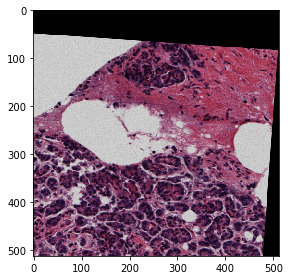

In [10]:
sample_aug, mask_aug = augment_seg(img1, mask1)
imshow(sample_aug)

## We can use each tile and generate 5 augmented tiles A-E

In [13]:
OUTPUT_FOLDER_AUG = f"data{TARGET_WIDTH}_aug"
OUTPUT_IMAGES_AUG = OUTPUT_FOLDER_AUG + "/images"
OUTPUT_MASKS_AUG = OUTPUT_FOLDER_AUG + "/annotations"
os.makedirs(OUTPUT_FOLDER_AUG, exist_ok=True)
os.makedirs(OUTPUT_IMAGES_AUG, exist_ok=True)
os.makedirs(OUTPUT_MASKS_AUG, exist_ok=True)

In [14]:
for img_path in tqdm(os.listdir(OUTPUT_IMAGES)):
    img = imread(os.path.join(OUTPUT_IMAGES, img_path))
    mask = imread(os.path.join(OUTPUT_MASKS, img_path))
    
    for i in "abcde":
        sample_aug, mask_aug = augment_seg(img, mask)
        imsave(os.path.join(OUTPUT_IMAGES_AUG, img_path.split(".png")[0] + f"_{i}.png"), sample_aug, check_contrast=False)
        imsave(os.path.join(OUTPUT_MASKS_AUG, img_path.split(".png")[0] + f"_{i}.png"), mask_aug, check_contrast=False)

## Preview some generated tiles

In [26]:
images = glob.glob(OUTPUT_IMAGES_AUG+"/*.png")
images = random.sample(images, 9)

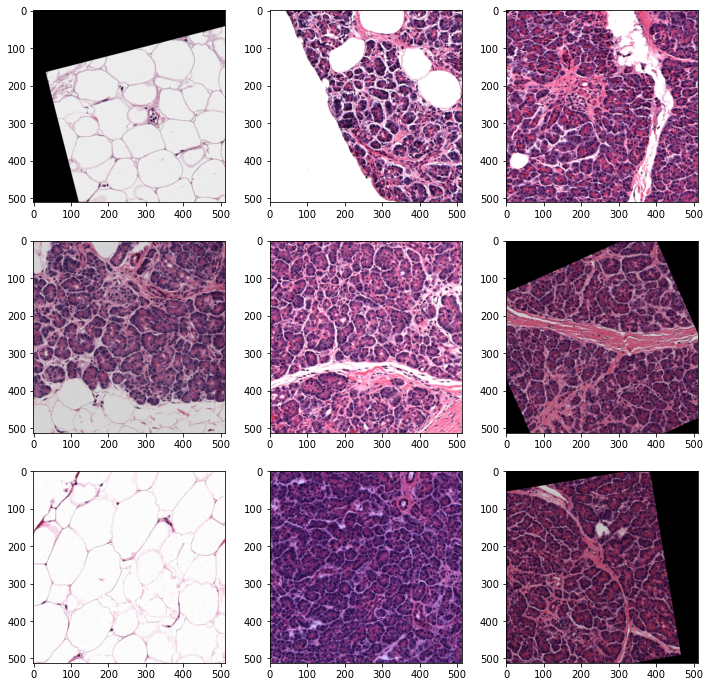

In [27]:
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(images, axs):
    im = imread(img)
    ax.imshow(im)
plt.show()